In [2]:
import numpy as np
import pandas as pd
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import os
import sys

path = os.getcwd()
os.chdir(path[:path.find("Estatística Básica")])
df = pd.read_csv(os.path.abspath("data/tabela2_1.csv"), sep=";", index_col="N")
df["Salario (x Sal Min)"] = df["Salario (x Sal Min)"].str.replace(",", ".").astype(float)


In [8]:
df.head()

,Estado Civil,Grau de Instrução,N de Filhos,Salario (x Sal Min),Anos,Meses,Região de Procedência
N,,,,,,,
1,solteiro,ensino fundamental,NaN,4.00,26,3,interior
2,casado,ensino fundamental,1.0,4.56,32,10,capital
3,casado,ensino fundamental,2.0,5.25,36,5,capital
4,solteiro,ensino médio,NaN,5.73,20,10,outra
5,solteiro,ensino fundamental,NaN,6.26,40,7,outra


# Análise Bidimensional

## Variáveis Qualitativas

In [9]:
df_pivot = pd.pivot_table(
    df[['Região de Procedência', 'Grau de Instrução']], 
    index="Região de Procedência",
    columns="Grau de Instrução", 
    aggfunc=lambda x: int(round(len(x) / len(df) * 100, 0)),
    margins=True,
    margins_name="Total",
)
df_pivot

Grau de Instrução,ensino fundamental,ensino médio,superior,Total
Região de Procedência,,,,
capital,11,14,6,31
interior,8,19,6,33
outra,14,17,6,36
Total,33,50,17,100


In [10]:
joint_df = (pd.crosstab(index=df["Região de Procedência"],
                       columns=df["Grau de Instrução"],
                       normalize="columns") * 100).round(0).astype(int)
joint_df.loc["Total"] = joint_df.sum()


<Axes: xlabel='Grau de Instrução'>

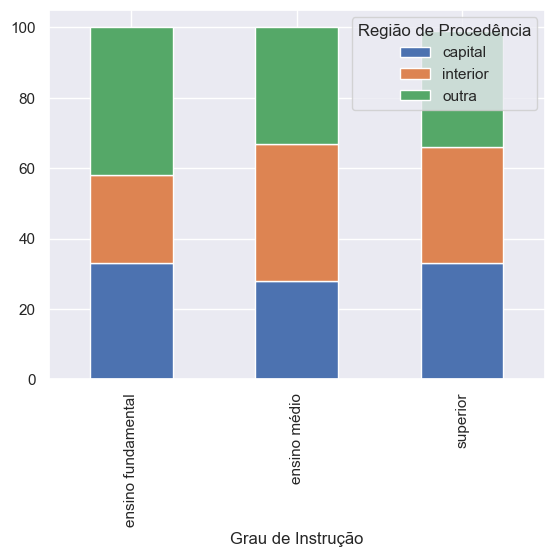

In [11]:
sns.set()
joint_df.iloc[:3].T.plot(kind='bar', stacked=True)


In [12]:
states = ["São Paulo", "Paraná", "Rio Grande do Sul"]
customers = [214, 51, 111]
products = [237, 102, 304]
school = [78, 126, 139]
others = [119, 22, 48]

df = pd.DataFrame(
    {
        "Estados": states,
        "Consumidor": customers,
        "Produtor": products,
        "Escola": school,
        "Outros": others
    }
)
df = df.set_index("Estados")
df_with_total = df.copy()
df_with_total.loc["Total"] = df_with_total.sum()
df_with_total["Total"] = df_with_total.sum(axis=1)

In [15]:
df_percents = (df_with_total.div(df_with_total["Total"], axis=0) * 100)
df_percents = df_percents.round(2)
df_percents

,Consumidor,Produtor,Escola,Outros,Total
Estados,,,,,
São Paulo,33.02,36.57,12.04,18.36,100.0
Paraná,16.94,33.89,41.86,7.31,100.0
Rio Grande do Sul,18.44,50.50,23.09,7.97,100.0
Total,24.24,41.46,22.11,12.19,100.0


In [16]:
df_espected = pd.DataFrame(
    {
        "Estados": states,
        "Consumidor": list(((df_percents.loc["Total", "Consumidor"] / 100) * df_with_total.loc[:, "Total"]).values)[:len(states)],
        "Produtor": list(((df_percents.loc["Total", "Produtor"] / 100) * df_with_total.loc[:, "Total"]).values)[:len(states)],
        "Escola": list(((df_percents.loc["Total", "Escola"] / 100) * df_with_total.loc[:, "Total"]).values)[:len(states)],
        "Outros": list(((df_percents.loc["Total", "Outros"] / 100) * df_with_total.loc[:, "Total"]).values)[:len(states)],
    }
)
df_espected = df_espected.set_index("Estados")
df_espected = df_espected.round(0).astype(int)
df_espected

,Consumidor,Produtor,Escola,Outros
Estados,,,,
São Paulo,157,269,143,79
Paraná,73,125,67,37
Rio Grande do Sul,146,250,133,73


In [17]:
df_desv = (df - df_espected).round(0).astype(int)
df_desv

,Consumidor,Produtor,Escola,Outros
Estados,,,,
São Paulo,57,-32,-65,40
Paraná,-22,-23,59,-15
Rio Grande do Sul,-35,54,6,-25


$$ \frac{(o_i - e_i)^2}{e_i} $$

In [18]:
sao_paulo_escole_qui_quadrado = ((df.loc["São Paulo", "Escola"] - df_espected.loc["São Paulo", "Escola"]) ** 2) / df_espected.loc["São Paulo", "Escola"]
sao_paulo_escole_qui_quadrado

29.545454545454547

Qui Quadrado

$$ \chi^2 = \sum_{i=1}^r \sum_{j=1}^s \frac{(n_{ij}-n_{ij}^*)^2}{n_{ij}^*} $$

In [24]:
r = df.shape[0]
c = df.shape[1]
n = df_with_total.loc["Total", "Total"]
qui_quadrado = ((df - df_espected) ** 2 / df_espected).sum().sum()
qui_quadrado

172.0847515023836

Coeficiente de Contingência

$$ C = \sqrt{\frac{\chi^2}{\chi^2 + n}} $$

In [32]:
C = sqrt(qui_quadrado / (qui_quadrado + n))
C

0.3160224058082541

Coeficiente Tschuprow

$$ T = \sqrt{\frac{\chi^2}{n\sqrt{(r-1)(s-1)}}} $$

In [26]:
T = sqrt(qui_quadrado / (n * sqrt((r - 1) * (c - 1))))
T

0.21282737230781038

Coeficiente de Crâmer

$$ V = \sqrt{\frac{\chi^2}{n \times \min{((r-1), (c-1))}}} $$

Sendo **r** o número de linhas (variável independente) e **c** o número de colunas (variável dependente).

In [29]:
V = sqrt(qui_quadrado / (n * (min(r-1, c-1))))
V

0.23553220495038263

## Variáveis Quantitativas

In [3]:
agentes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
ano_servico = [2, 3, 4, 5, 4, 6, 7, 8, 8, 10]
num_clientes = [48, 50, 56, 52, 43, 60, 62, 58, 64, 72]

df = pd.DataFrame(
    {
        "Agentes": agentes,
        "Anos de Serviço": ano_servico,
        "Número de Clientes": num_clientes
    }
)
df = df.set_index("Agentes")
df

,Anos de Serviço,Número de Clientes
Agentes,,
A,2,48
B,3,50
C,4,56
D,5,52
E,4,43
F,6,60
G,7,62
H,8,58
I,8,64


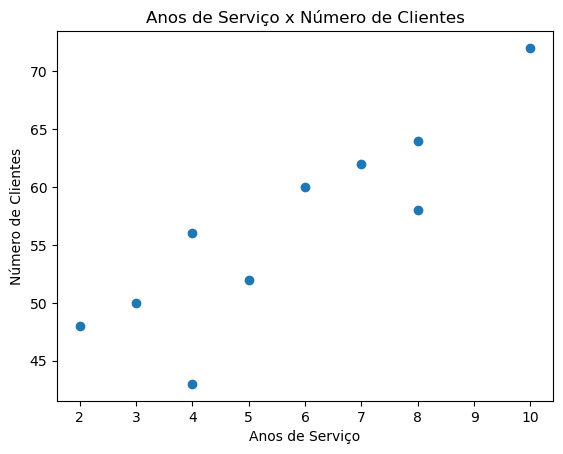

In [5]:

plt.scatter(df["Anos de Serviço"], df["Número de Clientes"])
plt.title("Anos de Serviço x Número de Clientes")
plt.xlabel("Anos de Serviço")
plt.ylabel("Número de Clientes")
plt.show()

Numa pesquisa feita com dez famílias com renda bruta mensal entre 10 e 60 salários mínimos, mediram-se a porcentagem da renda bruta anual gasta com assistência médica.

In [8]:
familia = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
renda = [12, 16, 18, 20, 28, 30, 40, 48, 50, 54]
gasto_medico = [7.2, 7.4, 7.0, 6.5, 6.6, 6.7, 6.0, 5.6, 6.0, 5.5]

df = pd.DataFrame(
    {
        "Família": familia,
        "Renda Bruta Mensal (Sal Min)": renda,
        "Gasto Médico Anual (% Anual)": gasto_medico
    }
)
df = df.set_index("Família")
df

,Renda Bruta Mensal (Sal Min),Gasto Médico Anual (% Anual)
Família,,
A,12,7.2
B,16,7.4
C,18,7.0
D,20,6.5
E,28,6.6
F,30,6.7
G,40,6.0
H,48,5.6
I,50,6.0


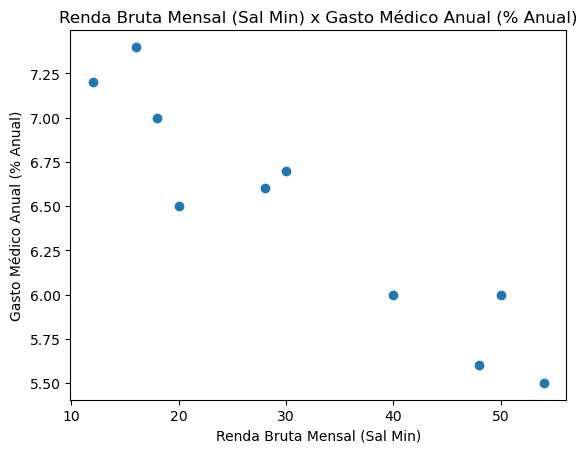

In [9]:
plt.scatter(df["Renda Bruta Mensal (Sal Min)"], df["Gasto Médico Anual (% Anual)"])
plt.title("Renda Bruta Mensal (Sal Min) x Gasto Médico Anual (% Anual)")
plt.xlabel("Renda Bruta Mensal (Sal Min)")
plt.ylabel("Gasto Médico Anual (% Anual)")
plt.show()

Oito indivíduos foram submetidos a um teste sobre conhecimento de língua estrangeira e, em seguida, mediu-se o tempo gasto para cada um aprender a operar uma determinada máquina.

In [12]:
individuos = ["A", "B", "C", "D", "E", "F", "G", "H"]
pontos_teste = [45, 52, 61, 70, 74, 76, 80, 90]
tempo_minutos = [343, 368, 355, 334, 337, 381, 345, 375]

df = pd.DataFrame(
    {
        "Indivíduos": individuos,
        "Pontos no Teste": pontos_teste,
        "Tempo (minutos)": tempo_minutos
    }
)
df = df.set_index("Indivíduos")
df

,Pontos no Teste,Tempo (minutos)
Indivíduos,,
A,45,343
B,52,368
C,61,355
D,70,334
E,74,337
F,76,381
G,80,345
H,90,375


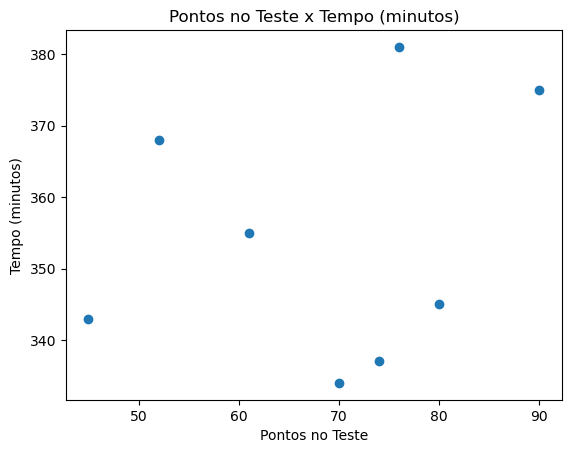

In [13]:
plt.scatter(df["Pontos no Teste"], df["Tempo (minutos)"])
plt.title("Pontos no Teste x Tempo (minutos)")
plt.xlabel("Pontos no Teste")
plt.ylabel("Tempo (minutos)")
plt.show()